# Análisis con 3 distintos métodos
Se hará un anaĺisis del algoritmo para calcular la distancia euclideana comparando con:

- Librería shapely
- Implementación propia Python/C++
- Implementación propia Python

In [15]:
import shapely

p1, p2 = shapely.Point(1,2), shapely.Point(1,3)
p3, p4 = shapely.Point(3,4), shapely.Point(3,5)
t1, t2 = shapely.GeometryCollection([p1, p2]), shapely.GeometryCollection([p3, p4])
l1, l2 = shapely.LineString([[1,2],[1,3]]), shapely.LineString([[3,4],[3,5]])
shapely.distance(t1, t2), shapely.distance(l1, l2)

(2.23606797749979, 2.23606797749979)

In [7]:
import cppyy

cppyy.include('/home/edev/devel/similarity-measures/src/euclidean.h')
cppyy.load_library('/home/edev/devel/similarity-measures/build/libeuclidean.so')
lib = cppyy.gbl

lib.distance([1.0, 2.0, 1.0, 3.0], [3.0, 4.0, 3.0, 5.0])

4.0

In [9]:
import src.euclidean as euclidean

euclidean.distance([1,2,1,3], [3,4,3,5])

4.0

Como anteriormente se vió, los resultados para trayectorias en Shapely tanto en colección de puntos (`GeometryCollection`) como en `LineString` dan un resultado distinto al algoritmo convencional euclideano (resultados que se pueden corroborar también en [Wolfram](https://www.wolframalpha.com/input?i=euclideandistance+%5B%7B1%2C2%2C1%2C3%7D%2C+%7B3%2C4%2C3%2C5%7D%5D)).

## Insertando datos
Para poder insertar `n` datos y comparar tiempos de ejecución en `shapely` se crearán objetos de tipo `LineString` (ya que, como anteriormente se observó, creando colecciones de punto o `LineString` arrojan el mismo resultado) que contengan `n` tuplas (de tipo `list`). Mientras que para nuestros otros métodos implementados, simplemente se creará un arreglo que contenga 2 elementos por cada `n` dada.

In [16]:
import random

In [21]:
def populate_linestring(n: int) -> shapely.LineString:
    arr = []

    for _ in range(n):
        arr.append([random.uniform(-99.0, -99.5), random.uniform(19.3, 19.5)])

    return shapely.LineString(arr)

In [24]:
def populate_lists(n: int) -> list[float]:
    arr = []

    for _ in range(n):
        arr.append(random.uniform(-99.0, -99.5))
        arr.append(random.uniform(19.3, 19.5))

    return arr

## Análisis de complejidad temporal
Teniendo esto, ahora es posible generar gráficas que nos permitan ver con `n` datos la complejidad temporal que tienen estos 3 métodos para calcular la distancia euclideana de trayectorias simuladas.

In [54]:
import timeit
import matplotlib.pyplot as plt

def plot_tcs_distance_fns(max_input_size=1000):
    """Plots time complexities of multiple distance functions in subplots."""

    functions = [
        (shapely.distance, populate_linestring, "Shapely"),
        (lib.distance, populate_lists, "Python/C++"),
        (euclidean.distance, populate_lists, "Python"),
    ]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

    for ax, (fn, populate_fn, plot_title) in zip(axs, functions):
        times = []
        for i in range(2, max_input_size):
            t1 = populate_fn(i)
            t2 = populate_fn(i)

            start = timeit.default_timer()
            fn(t1, t2)
            end = timeit.default_timer() - start

            times.append(end)

        ax.plot(times)
        ax.set_title(plot_title)
        ax.set_xlabel("Input size")
        ax.set_ylabel("Time")

    plt.tight_layout()  # Adjust subplot spacing
    plt.show()

### Análisis con vectores de tamaño 1000

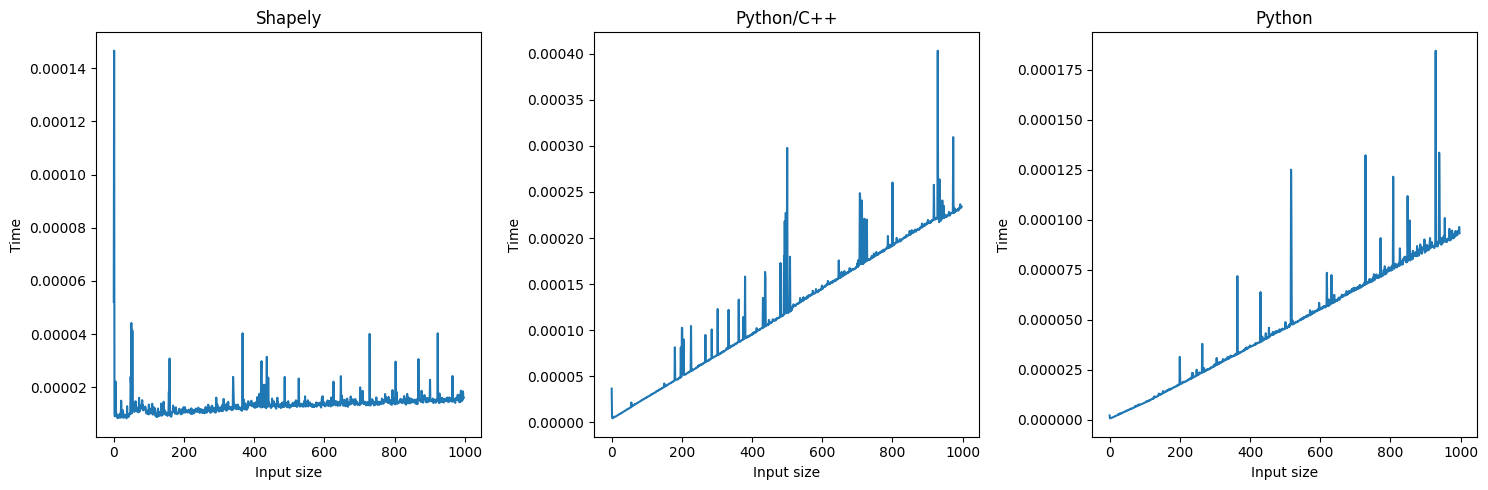

In [50]:
plot_tcs_distance_fns()

### Análisis con vectores de tamaño 2000

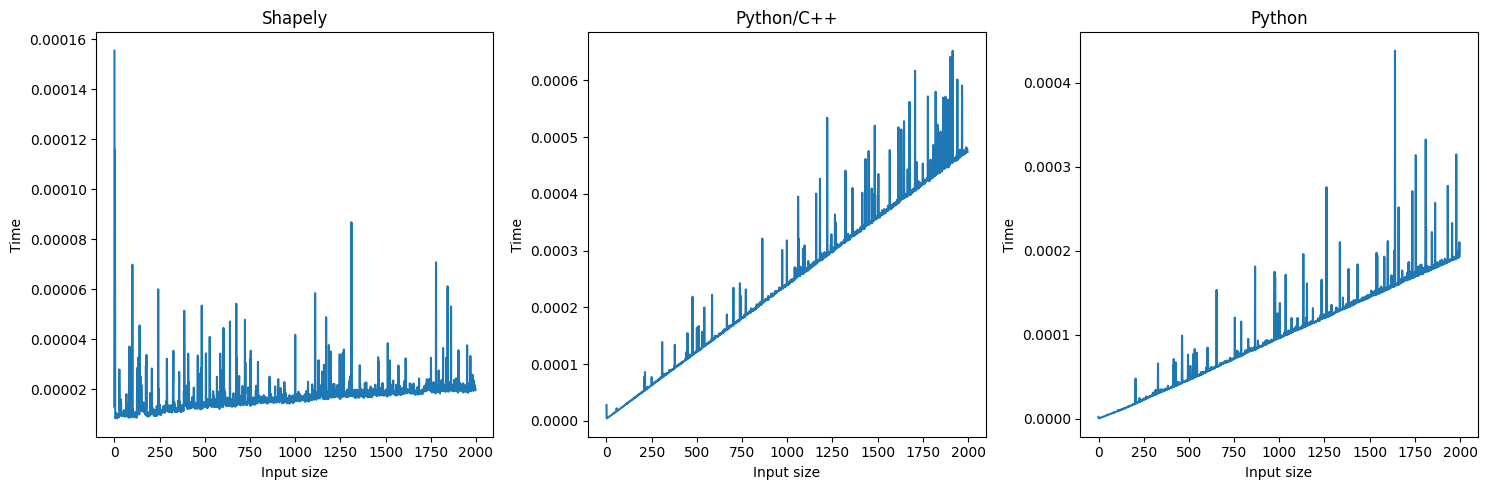

In [51]:
plot_tcs_distance_fns(2000)

### Análisis con vectores de tamaño 4000

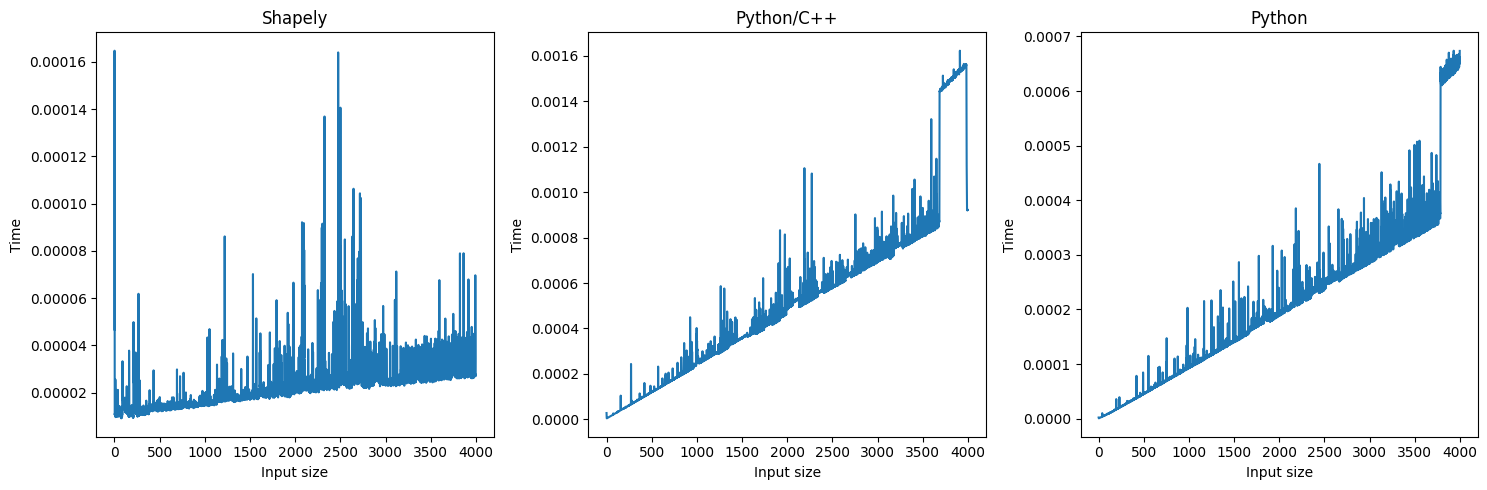

In [52]:
plot_tcs_distance_fns(4000)

### Análisis con vectores de tamaño 8000

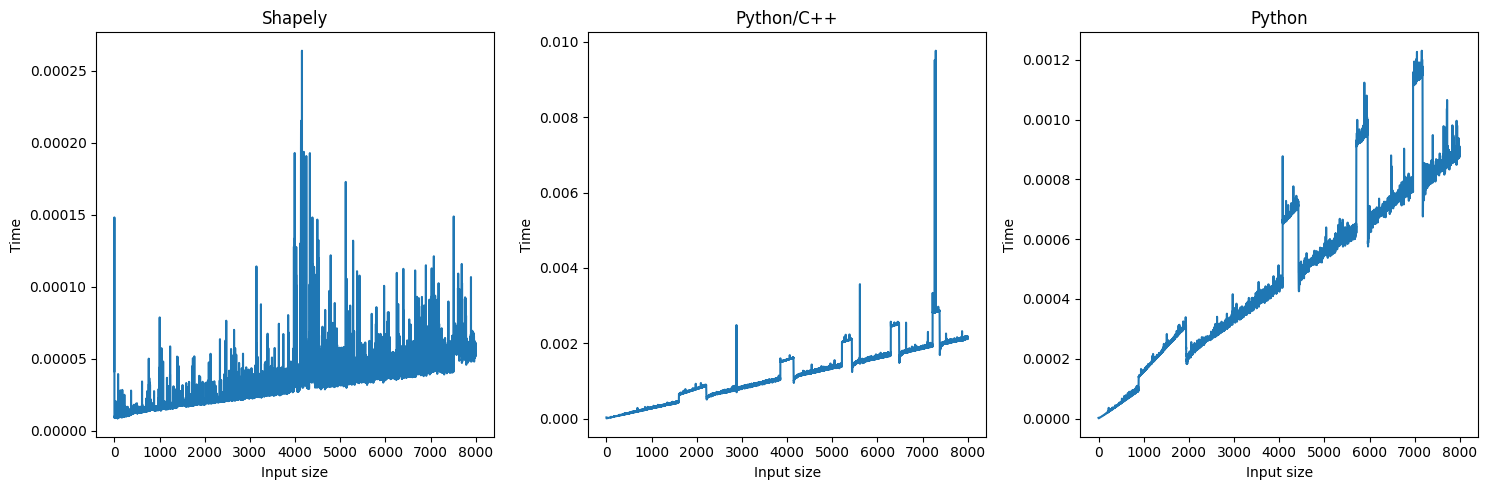

In [53]:
plot_tcs_distance_fns(8000)

### Análisis solo en C++
Para esto se utilizaron las siguientes librerias:

```c++
#include <vector>
#include <chrono>
#include <fstream>
```

Y se calcularon los tiempos dentro de un `main` que a su vez guardó estos tiempos en un archivo llamado `distance_times.txt`:

```c++
int main() {
  using namespace std::chrono;

  std::ofstream outfile("distance_times.txt");  // Open output file

  if (!outfile.is_open()) {
    std::cerr << "Error: Could not open output file." << std::endl;
    return 1;
  }

  for (size_t input_size = 2; input_size <= 10000; ++input_size) {
    std::vector<double> p(input_size, 1.0);
    std::vector<double> q(input_size, 2.0);

    auto start = high_resolution_clock::now();
    distance(p, q);
    auto stop = high_resolution_clock::now();

    auto duration = duration_cast<nanoseconds>(stop - start);
    long long timens = duration.count();
    outfile << input_size << " " << timens << std::endl;
  }

  outfile.close();

  return 0;
}
```

Por último se cargaron estos datos en Python y se convirtieron los nanosegundos guardados en el archivo a segundos para poder comparar con los anteriores métodos.

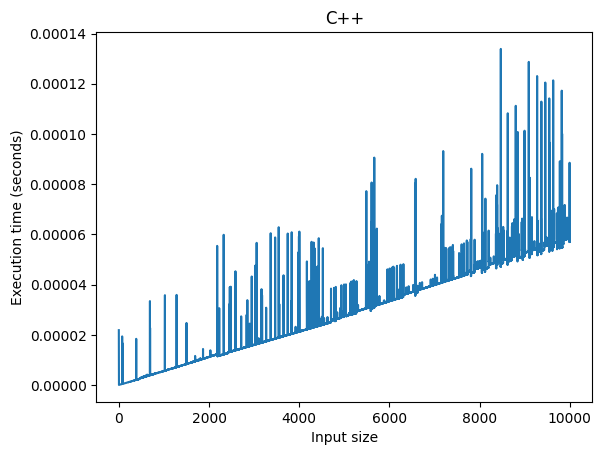

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Read data from the file
data = np.loadtxt("src/distance_times.txt")

# Separate data into input sizes and execution times
input_sizes = data[:, 0]
execution_times_ns = data[:, 1]

# Convert nanoseconds to seconds with leading zeros
execution_times_s = execution_times_ns / 1e9  # 1e9 = 1 billion (nanoseconds per second)

# Plot the data with formatted labels
plt.plot(execution_times_s)
plt.xlabel("Input size")
plt.ylabel("Execution time (seconds)")
plt.title("C++")

plt.show()